In [52]:
import warnings
warnings.filterwarnings("ignore")

In [53]:
from sklearn.datasets import fetch_openml
import numpy as np

In [54]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [55]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [56]:
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist)

In [57]:
X, y = mnist["data"], mnist["target"]

In [58]:
X.shape

(70000, 784)

In [59]:
y.shape

(70000,)

In [60]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [61]:
some_digits = X[36000]
some_digits_image = some_digits.reshape(28,28)

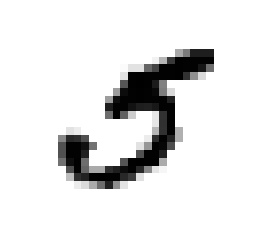

In [62]:
plt.imshow(some_digits_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [63]:
y[36000]

5

In [64]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [65]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [66]:
y_train_5 = (y_train == 5)
y_train_5

array([False, False, False, ..., False, False, False])

In [67]:
y_test_5 = (y_test == 5)
y_test_5

array([False, False, False, ..., False, False, False])

In [68]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [69]:
sgd_clf.predict([some_digits])

array([ True])

# Cross-Validation

In [70]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.96425
0.95215
0.9612


In [71]:
from sklearn.model_selection import cross_val_score

In [72]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96425, 0.95215, 0.9612 ])

## Accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets.

In [73]:
from sklearn.base import BaseEstimator
import numpy as np

In [74]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [75]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")    # score

array([0.9112 , 0.9059 , 0.91185])

# Confusion Matrix

In [76]:
from sklearn.model_selection import cross_val_predict

In [77]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)      # predict
y_train_pred

array([False, False, False, ..., False, False, False])

In [78]:
from sklearn.metrics import confusion_matrix

In [79]:
confusion_matrix(y_train_5, y_train_pred)

array([[53536,  1043],
       [ 1405,  4016]])

In [80]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

# Precision and Recall

In [81]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7938327732753508

In [82]:
recall_score(y_train_5, y_train_pred)

0.7408227264342372

In [83]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.766412213740458

In [84]:
y_scores = sgd_clf.decision_function([some_digits])
y_scores

array([186495.98413477])

In [85]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [86]:
sgd_clf.predict([some_digits])

array([ True])

In [87]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### ==> Rasing the threshold decreases recall. 

In [88]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [89]:
y_scores

array([-793727.29229332,  -25015.80616653, -363318.48428931, ...,
       -836845.56813265, -227498.90471642, -448799.80671096])